# Titanic - Fold-Safe版 (StratifiedKFold)

## 🎯 改善点:
- ✅ **Fold-Safe前処理**: 各Foldで統計量を再計算
- ✅ **StratifiedKFold**: クラスバランス維持
- ✅ **Is_Married修正**: Title統合前に判定
- ✅ **最適閾値探索**: OOFで最適化
- ✅ **メタ学習**: 重み最適化
- ✅ **CatBoost最適化**: 文字列カテゴリ使用
- ✅ **数値特徴量**: Age, Fareを連続値で使用
- ✅ **学習曲線可視化**: CatBoost & XGBoostの学習過程
- ✅ **詳細メトリクス**: ROC-AUC, Logloss, Accuracyの可視化
- ✅ **SHAP分析**: 特徴量重要度とモデル解釈性の可視化

## 1. セットアップ

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import string
import pickle
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

import shap

RANDOM_STATE = 42
N_FOLDS = 5

np.random.seed(RANDOM_STATE)

print("ライブラリのインポート完了")

ライブラリのインポート完了


In [60]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nTarget distribution:")
print(df_train['Perished'].value_counts(normalize=True))

Train shape: (891, 12)
Test shape: (418, 11)

Target distribution:
Perished
1    0.616162
0    0.383838
Name: proportion, dtype: float64


## 2. 基本特徴量作成（Fold-independent）

In [61]:
def extract_surname(data):
    """名前から姓を抽出"""
    families = []
    for i in range(len(data)):
        name = data.iloc[i]
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name
        family = name_no_bracket.split(',')[0]
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        families.append(family)
    return families


def create_base_features(df):
    """
    Fold-independentな基本特徴量のみ作成
    統計量を使う特徴量はFold内で作成する
    """
    data = df.copy()
    
    # 1. Title抽出（生のまま保持）
    data['Title_raw'] = data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    
    # 2. Is_Married（Title統合前に判定）
    data['Is_Married'] = (data['Title_raw'] == 'Mrs').astype(int)
    
    # 3. Title正規化
    data['Title'] = data['Title_raw'].replace(
        ['Miss', 'Mrs', 'Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms'
    )
    data['Title'] = data['Title'].replace(
        ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy'
    )
    
    # 4. Family（姓）
    data['Family'] = extract_surname(data['Name'])
    
    # 5. Family_Size
    data['Family_Size'] = data['SibSp'] + data['Parch'] + 1
    
    # 6. Family_Size_Grouped
    family_map = {
        1: 'Alone',
        2: 'Small', 3: 'Small', 4: 'Small',
        5: 'Medium', 6: 'Medium',
        7: 'Large', 8: 'Large', 11: 'Large'
    }
    data['Family_Size_Grouped'] = data['Family_Size'].map(family_map)
    
    # 7. Deck
    data['Deck'] = data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    data['Deck'] = data['Deck'].replace(['A', 'B', 'C'], 'ABC')
    data['Deck'] = data['Deck'].replace(['D', 'E'], 'DE')
    data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')
    data['Deck'] = data['Deck'].replace(['T'], 'M')
    
    # 8. Embarked補完
    data['Embarked'] = data['Embarked'].fillna('S')
    
    # 9. Sex x Pclass 交互作用
    data['Sex_Pclass'] = data['Sex'] + '_' + data['Pclass'].astype(str)
    
    # Age, Fareは元のまま保持（Fold内で補完する）
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
    
    return data


# 基本特徴量作成
train_base = create_base_features(df_train)
test_base = create_base_features(df_test)

print(f"✅ 基本特徴量作成完了")
print(f"Train shape: {train_base.shape}")
print(f"Test shape: {test_base.shape}")
print(f"Is_Married有効数: {train_base['Is_Married'].sum()}件")

✅ 基本特徴量作成完了
Train shape: (891, 20)
Test shape: (418, 19)
Is_Married有効数: 125件


## 3. ハイパーパラメータ設定

In [62]:
best_params_randomforest = {
    'n_estimators': 1200,
    'max_depth': 6,
    'min_samples_split': 6,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',
    'bootstrap': True,
    'max_samples': 0.9,
    'criterion': 'gini',
    'class_weight': None,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

best_params_catboost = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'depth': 6,
    'l2_leaf_reg': 6.0,
    'bagging_temperature': 0.5,
    'random_strength': 1.0,
    'rsm': 0.9,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_state': RANDOM_STATE,
    'verbose': 0
}

best_params_xgboost = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'max_depth': 3,
    'min_child_weight': 5,
    'gamma': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 1.5,
    'random_state': RANDOM_STATE,
    'eval_metric': 'logloss',
    'tree_method': 'hist'
}

print("ハイパーパラメータ設定完了")

ハイパーパラメータ設定完了


## 4. Fold-Safe学習関数

In [ ]:
def apply_fold_safe_features(train_data, valid_data, test_data, train_indices):
    """
    🎯 Fold-Safe: 各Foldのtrain setのみで統計量を計算
    """
    train_fold = train_data.iloc[train_indices].copy()
    
    # 1. Ticket_Frequency（Fold trainのみで計算）
    # fold_ticket_map = train_fold.groupby('Ticket').size().to_dict()
    
    # train_data['Ticket_Frequency'] = train_data['Ticket'].map(fold_ticket_map).fillna(1)
    # valid_data['Ticket_Frequency'] = valid_data['Ticket'].map(fold_ticket_map).fillna(1)
    # test_data['Ticket_Frequency'] = test_data['Ticket'].map(fold_ticket_map).fillna(1)
    
    # 2. Age補完（Fold trainのみの中央値）
    fold_age_median = train_fold.groupby(['Sex', 'Pclass'])['Age'].median()
    
    for data in [train_data, valid_data, test_data]:
        for pclass in [1, 2, 3]:
            for sex in ['male', 'female']:
                mask = (data['Age'].isnull()) & (data['Pclass'] == pclass) & (data['Sex'] == sex)
                if mask.any():
                    data.loc[mask, 'Age'] = fold_age_median.loc[(sex, pclass)]
    
    # Age_Band
    for data in [train_data, valid_data, test_data]:
        data['Age_Band'] = pd.cut(data['Age'], bins=[0, 12, 18, 30, 50, 80], 
                                   labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # 3. Fare補完（Fold trainのみの統計量）
    fold_fare_median = train_fold['Fare'].median()
    fold_fare_quantiles = train_fold['Fare'].quantile([0.25, 0.5, 0.75]).values
    
    for data in [train_data, valid_data, test_data]:
        data['Fare'] = data['Fare'].fillna(fold_fare_median)
        data['Fare_Band'] = pd.cut(
            data['Fare'],
            bins=[-np.inf] + fold_fare_quantiles.tolist() + [np.inf],
            labels=['Low', 'Medium', 'High', 'Very_High']
        )
    
    return train_data, valid_data, test_data


def prepare_fold_data(train_data, valid_data, test_data, cat_features):
    """
    Fold用のデータを準備（RF/XGB用とCatBoost用）
    """
    feature_cols = [
         'Is_Married',
        'Embarked', 'Title', 'Family_Size_Grouped', 'Deck',
        'Age_Band', 'Fare_Band', 'Sex_Pclass',
        #'Age', 'Fare', 'Family_Size','Pclass',
        #  'Ticket_Frequency'
    ]
    
    # データ抽出
    X_train = train_data[feature_cols].copy()
    y_train = train_data['Perished'].copy()
    X_valid = valid_data[feature_cols].copy()
    y_valid = valid_data['Perished'].copy()
    X_test = test_data[feature_cols].copy()
    
    # CatBoost用（文字列のまま）
    X_train_cat = X_train.copy()
    X_valid_cat = X_valid.copy()
    X_test_cat = X_test.copy()
    
    # RF/XGB用（LabelEncoder）
    X_train_enc = X_train.copy()
    X_valid_enc = X_valid.copy()
    X_test_enc = X_test.copy()
    
    for col in cat_features:
        le = LabelEncoder()
        le.fit(X_train_enc[col].astype(str))
        
        X_train_enc[col] = le.transform(X_train_enc[col].astype(str))
        
        # Valid/Testの未知カテゴリ処理
        for X_data in [X_valid_enc, X_test_enc]:
            unknown_mask = ~X_data[col].astype(str).isin(le.classes_)
            if unknown_mask.any():
                X_data.loc[unknown_mask, col] = X_train[col].mode()[0]
            X_data[col] = le.transform(X_data[col].astype(str))
    
    return X_train_enc, X_train_cat, y_train, X_valid_enc, X_valid_cat, y_valid, X_test_enc, X_test_cat


print("✅ Fold-Safe関数定義完了")

✅ Fold-Safe関数定義完了



Categorical features: ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']


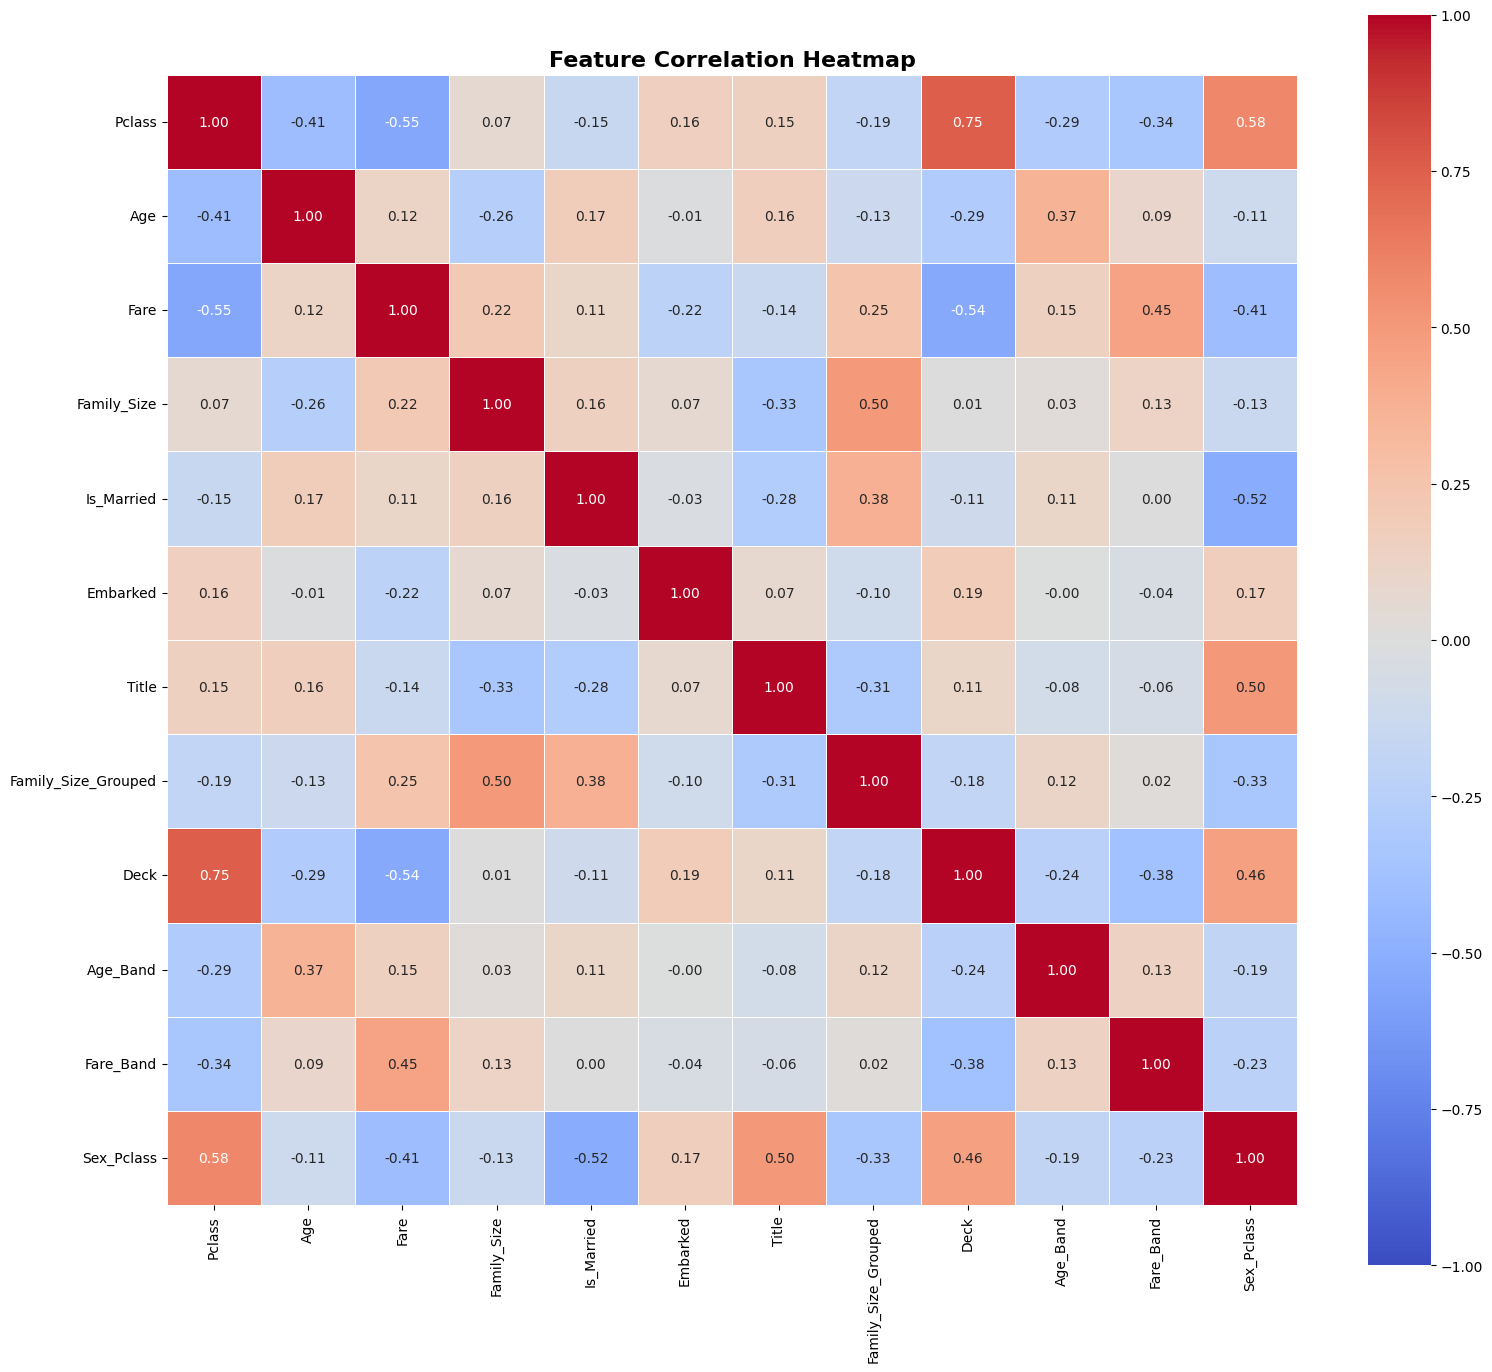


相関ヒートマップを保存: ../output/correlation_heatmap.png


In [64]:
def prepare_data(feature_cols):
    """
    特徴量からデータを準備（相関分析用）
    """
    # 基本特徴量作成（既存の関数を使用）
    train_data = train_base.copy()
    test_data = test_base.copy()
    
    # Fold-Safe特徴量を全データで作成（可視化用のみ）
    # 注意: これは可視化目的であり、モデル学習には使用しない
    train_indices = train_data.index
    
    # Ticket_Frequency
    # ticket_map = train_data.groupby('Ticket').size().to_dict()
    # train_data['Ticket_Frequency'] = train_data['Ticket'].map(ticket_map).fillna(1)
    # test_data['Ticket_Frequency'] = test_data['Ticket'].map(ticket_map).fillna(1)
    
    # Age補完
    age_median = train_data.groupby(['Sex', 'Pclass'])['Age'].median()
    for data in [train_data, test_data]:
        for pclass in [1, 2, 3]:
            for sex in ['male', 'female']:
                mask = (data['Age'].isnull()) & (data['Pclass'] == pclass) & (data['Sex'] == sex)
                if mask.any():
                    data.loc[mask, 'Age'] = age_median.loc[(sex, pclass)]
    
    # Age_Band
    for data in [train_data, test_data]:
        data['Age_Band'] = pd.cut(data['Age'], bins=[0, 12, 18, 30, 50, 80], 
                                   labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # Fare補完
    fare_median = train_data['Fare'].median()
    fare_quantiles = train_data['Fare'].quantile([0.25, 0.5, 0.75]).values
    
    for data in [train_data, test_data]:
        data['Fare'] = data['Fare'].fillna(fare_median)
        data['Fare_Band'] = pd.cut(
            data['Fare'],
            bins=[-np.inf] + fare_quantiles.tolist() + [np.inf],
            labels=['Low', 'Medium', 'High', 'Very_High']
        )
    
    # 特徴量抽出
    X = train_data[feature_cols].copy()
    y = train_data['Perished'].copy()
    X_test = test_data[feature_cols].copy()
    
    # カテゴリカル特徴量リスト
    cat_features = ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']
    
    # LabelEncoderでエンコード（相関分析用）
    for col in cat_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
    
    return X, y, X_test, cat_features


# 実行
feature_cols = [
    'Pclass', 'Age', 'Fare', 'Family_Size', 'Is_Married',
    'Embarked', 'Title', 'Family_Size_Grouped',  'Deck',
    'Age_Band', 'Fare_Band', 'Sex_Pclass'
    #'Ticket_Frequency'  --- IGNORE ---
]

X, y, X_test, cat_features = prepare_data(feature_cols)
print(f"\nCategorical features: {cat_features}")

# 相関ヒートマップ
corr = X.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr,
    annot=True,          # 数値を表示
    fmt=".2f",           # 小数点2桁
    cmap="coolwarm",
    square=True,
    linewidths=0.5,      # 枠線
    cbar=True,           # カラーバー
    vmin=-1,             # 最小値
    vmax=1               # 最大値
)
plt.title("Feature Correlation Heatmap", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n相関ヒートマップを保存: ../output/correlation_heatmap.png")

## 5. StratifiedKFold + Fold-Safe学習

In [65]:
def train_fold_safe_models(train_base, test_base, n_folds=5):
    """
    🎯 StratifiedKFold + Fold-Safe前処理で学習
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    
    y = train_base['Perished']
    
    # OOF予測保存用
    oof_proba_rf = np.zeros(len(train_base))
    oof_proba_cat = np.zeros(len(train_base))
    oof_proba_xgb = np.zeros(len(train_base))
    
    test_proba_rf = np.zeros((len(test_base), n_folds))
    test_proba_cat = np.zeros((len(test_base), n_folds))
    test_proba_xgb = np.zeros((len(test_base), n_folds))
    
    models_rf = []
    models_cat = []
    models_xgb = []
    
    train_scores = {'rf': [], 'cat': [], 'xgb': []}
    valid_scores = {'rf': [], 'cat': [], 'xgb': []}
    
    # 🎯 学習曲線保存用
    learning_curves_cat = []
    learning_curves_xgb = []
    
    # 🎯 メトリクス保存用
    metrics_history = {
        'rf': {'train_acc': [], 'valid_acc': [], 'train_logloss': [], 'valid_logloss': [], 'valid_roc_auc': []},
        'cat': {'train_acc': [], 'valid_acc': [], 'train_logloss': [], 'valid_logloss': [], 'valid_roc_auc': []},
        'xgb': {'train_acc': [], 'valid_acc': [], 'train_logloss': [], 'valid_logloss': [], 'valid_roc_auc': []}
    }
    
    # 🎯 SHAP用にデータを保存（Fold 1のみ）
    shap_data = {}
    
    cat_features = ['Embarked', 'Title', 'Family_Size_Grouped', 'Deck', 'Age_Band', 'Fare_Band', 'Sex_Pclass']
    
    print("="*60)
    print("🎯 Fold-Safe + StratifiedKFold Training")
    print("="*60)
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train_base, y)):
        print(f"\n{'='*60}")
        print(f"Fold {fold + 1}/{n_folds}")
        print(f"  Train: {len(train_idx)} samples, Valid: {len(valid_idx)} samples")
        
        # クラス分布確認
        train_dist = y.iloc[train_idx].value_counts(normalize=True)
        valid_dist = y.iloc[valid_idx].value_counts(normalize=True)
        print(f"  Train distribution: {train_dist[1]:.3f} Perished")
        print(f"  Valid distribution: {valid_dist[1]:.3f} Perished")
        print(f"{'='*60}")
        
        # データコピー
        train_fold = train_base.copy()
        valid_fold = train_base.iloc[valid_idx].copy()
        test_fold = test_base.copy()
        
        # 🎯 Fold-Safe特徴量作成
        train_fold, valid_fold, test_fold = apply_fold_safe_features(
            train_fold, valid_fold, test_fold, train_idx
        )
        
        # データ準備
        X_train_enc, X_train_cat, y_train, X_valid_enc, X_valid_cat, y_valid, X_test_enc, X_test_cat = prepare_fold_data(
            train_fold.iloc[train_idx], valid_fold, test_fold, cat_features
        )
        
        # 🎯 SHAP用にFold 1のデータを保存
        if fold == 0:
            shap_data['X_train_enc'] = X_train_enc
            shap_data['X_train_cat'] = X_train_cat
            shap_data['y_train'] = y_train
            shap_data['feature_names'] = X_train_enc.columns.tolist()
        
        # RandomForest
        print("\n[1/3] Training RandomForest...")
        model_rf = RandomForestClassifier(**best_params_randomforest)
        model_rf.fit(X_train_enc, y_train)
        
        oof_proba_rf[valid_idx] = model_rf.predict_proba(X_valid_enc)[:, 1]
        test_proba_rf[:, fold] = model_rf.predict_proba(X_test_enc)[:, 1]
        models_rf.append(model_rf)
        
        train_proba_rf = model_rf.predict_proba(X_train_enc)[:, 1]
        valid_proba_rf = model_rf.predict_proba(X_valid_enc)[:, 1]
        
        train_acc_rf = accuracy_score(y_train, model_rf.predict(X_train_enc))
        valid_acc_rf = accuracy_score(y_valid, model_rf.predict(X_valid_enc))
        train_logloss_rf = log_loss(y_train, train_proba_rf)
        valid_logloss_rf = log_loss(y_valid, valid_proba_rf)
        valid_roc_auc_rf = roc_auc_score(y_valid, valid_proba_rf)
        
        train_scores['rf'].append(train_acc_rf)
        valid_scores['rf'].append(valid_acc_rf)
        
        metrics_history['rf']['train_acc'].append(train_acc_rf)
        metrics_history['rf']['valid_acc'].append(valid_acc_rf)
        metrics_history['rf']['train_logloss'].append(train_logloss_rf)
        metrics_history['rf']['valid_logloss'].append(valid_logloss_rf)
        metrics_history['rf']['valid_roc_auc'].append(valid_roc_auc_rf)
        
        print(f"  Acc: Train {train_acc_rf:.4f} | Valid {valid_acc_rf:.4f} | Gap {train_acc_rf - valid_acc_rf:.4f}")
        print(f"  Logloss: Train {train_logloss_rf:.4f} | Valid {valid_logloss_rf:.4f}")
        print(f"  ROC-AUC: Valid {valid_roc_auc_rf:.4f}")
        
        # CatBoost
        print("\n[2/3] Training CatBoost...")
        train_pool = Pool(X_train_cat, y_train, cat_features=cat_features)
        valid_pool = Pool(X_valid_cat, y_valid, cat_features=cat_features)
        test_pool = Pool(X_test_cat, cat_features=cat_features)
        
        model_cat = CatBoostClassifier(**best_params_catboost)
        model_cat.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
        
        # 🎯 学習曲線を取得
        evals_result_cat = model_cat.get_evals_result()
        learning_curves_cat.append(evals_result_cat)
        
        oof_proba_cat[valid_idx] = model_cat.predict_proba(valid_pool)[:, 1]
        test_proba_cat[:, fold] = model_cat.predict_proba(test_pool)[:, 1]
        models_cat.append(model_cat)
        
        train_proba_cat = model_cat.predict_proba(train_pool)[:, 1]
        valid_proba_cat = model_cat.predict_proba(valid_pool)[:, 1]
        
        train_acc_cat = accuracy_score(y_train, model_cat.predict(train_pool))
        valid_acc_cat = accuracy_score(y_valid, model_cat.predict(valid_pool))
        train_logloss_cat = log_loss(y_train, train_proba_cat)
        valid_logloss_cat = log_loss(y_valid, valid_proba_cat)
        valid_roc_auc_cat = roc_auc_score(y_valid, valid_proba_cat)
        
        train_scores['cat'].append(train_acc_cat)
        valid_scores['cat'].append(valid_acc_cat)
        
        metrics_history['cat']['train_acc'].append(train_acc_cat)
        metrics_history['cat']['valid_acc'].append(valid_acc_cat)
        metrics_history['cat']['train_logloss'].append(train_logloss_cat)
        metrics_history['cat']['valid_logloss'].append(valid_logloss_cat)
        metrics_history['cat']['valid_roc_auc'].append(valid_roc_auc_cat)
        
        print(f"  Acc: Train {train_acc_cat:.4f} | Valid {valid_acc_cat:.4f} | Gap {train_acc_cat - valid_acc_cat:.4f}")
        print(f"  Logloss: Train {train_logloss_cat:.4f} | Valid {valid_logloss_cat:.4f}")
        print(f"  ROC-AUC: Valid {valid_roc_auc_cat:.4f}")
        
        # XGBoost
        print("\n[3/3] Training XGBoost...")
        model_xgb = XGBClassifier(**best_params_xgboost)
        
        # 🎯 eval_resultを取得するため
        evals_result_xgb = {}
        model_xgb.fit(
            X_train_enc, y_train,
            eval_set=[(X_train_enc, y_train), (X_valid_enc, y_valid)],
            verbose=0,
            early_stopping_rounds=50
        )
        evals_result_xgb = model_xgb.evals_result()
        learning_curves_xgb.append(evals_result_xgb)
        
        oof_proba_xgb[valid_idx] = model_xgb.predict_proba(X_valid_enc)[:, 1]
        test_proba_xgb[:, fold] = model_xgb.predict_proba(X_test_enc)[:, 1]
        models_xgb.append(model_xgb)
        
        train_proba_xgb = model_xgb.predict_proba(X_train_enc)[:, 1]
        valid_proba_xgb = model_xgb.predict_proba(X_valid_enc)[:, 1]
        
        train_acc_xgb = accuracy_score(y_train, model_xgb.predict(X_train_enc))
        valid_acc_xgb = accuracy_score(y_valid, model_xgb.predict(X_valid_enc))
        train_logloss_xgb = log_loss(y_train, train_proba_xgb)
        valid_logloss_xgb = log_loss(y_valid, valid_proba_xgb)
        valid_roc_auc_xgb = roc_auc_score(y_valid, valid_proba_xgb)
        
        train_scores['xgb'].append(train_acc_xgb)
        valid_scores['xgb'].append(valid_acc_xgb)
        
        metrics_history['xgb']['train_acc'].append(train_acc_xgb)
        metrics_history['xgb']['valid_acc'].append(valid_acc_xgb)
        metrics_history['xgb']['train_logloss'].append(train_logloss_xgb)
        metrics_history['xgb']['valid_logloss'].append(valid_logloss_xgb)
        metrics_history['xgb']['valid_roc_auc'].append(valid_roc_auc_xgb)
        
        print(f"  Acc: Train {train_acc_xgb:.4f} | Valid {valid_acc_xgb:.4f} | Gap {train_acc_xgb - valid_acc_xgb:.4f}")
        print(f"  Logloss: Train {train_logloss_xgb:.4f} | Valid {valid_logloss_xgb:.4f}")
        print(f"  ROC-AUC: Valid {valid_roc_auc_xgb:.4f}")
    
    # CV結果サマリー
    print(f"\n{'='*60}")
    print("Cross-Validation Results (Fold-Safe + StratifiedKFold)")
    print(f"{'='*60}")
    
    for name, key in [('RandomForest', 'rf'), ('CatBoost', 'cat'), ('XGBoost', 'xgb')]:
        train_mean = np.mean(train_scores[key])
        train_std = np.std(train_scores[key])
        valid_mean = np.mean(valid_scores[key])
        valid_std = np.std(valid_scores[key])
        gap = train_mean - valid_mean
        
        valid_logloss_mean = np.mean(metrics_history[key]['valid_logloss'])
        valid_roc_auc_mean = np.mean(metrics_history[key]['valid_roc_auc'])
        
        print(f"{name}:")
        print(f"  Accuracy: Train {train_mean:.4f} ± {train_std:.4f} | Valid {valid_mean:.4f} ± {valid_std:.4f} | Gap {gap:.4f}")
        print(f"  Logloss:  Valid {valid_logloss_mean:.4f}")
        print(f"  ROC-AUC:  Valid {valid_roc_auc_mean:.4f}")
    
    return {
        'oof_proba_rf': oof_proba_rf,
        'oof_proba_cat': oof_proba_cat,
        'oof_proba_xgb': oof_proba_xgb,
        'test_proba_rf': test_proba_rf.mean(axis=1),
        'test_proba_cat': test_proba_cat.mean(axis=1),
        'test_proba_xgb': test_proba_xgb.mean(axis=1),
        'models_rf': models_rf,
        'models_cat': models_cat,
        'models_xgb': models_xgb,
        'y': y,
        'learning_curves': {'cat': learning_curves_cat, 'xgb': learning_curves_xgb},
        'metrics_history': metrics_history,
        'shap_data': shap_data
    }


# 学習実行
results = train_fold_safe_models(train_base, test_base, n_folds=N_FOLDS)

🎯 Fold-Safe + StratifiedKFold Training

Fold 1/5
  Train: 712 samples, Valid: 179 samples
  Train distribution: 0.617 Perished
  Valid distribution: 0.615 Perished

[1/3] Training RandomForest...
  Acc: Train 0.8666 | Valid 0.8380 | Gap 0.0286
  Logloss: Train 0.3374 | Valid 0.3751
  ROC-AUC: Valid 0.9097

[2/3] Training CatBoost...
  Acc: Train 0.8624 | Valid 0.8436 | Gap 0.0188
  Logloss: Train 0.3577 | Valid 0.3767
  ROC-AUC: Valid 0.9088

[3/3] Training XGBoost...
  Acc: Train 0.8848 | Valid 0.8603 | Gap 0.0245
  Logloss: Train 0.3156 | Valid 0.3610
  ROC-AUC: Valid 0.9176

Fold 2/5
  Train: 713 samples, Valid: 178 samples
  Train distribution: 0.616 Perished
  Valid distribution: 0.618 Perished

[1/3] Training RandomForest...
  Acc: Train 0.8696 | Valid 0.8596 | Gap 0.0100
  Logloss: Train 0.3354 | Valid 0.3843
  ROC-AUC: Valid 0.8836

[2/3] Training CatBoost...
  Acc: Train 0.8808 | Valid 0.8652 | Gap 0.0156
  Logloss: Train 0.3098 | Valid 0.3562
  ROC-AUC: Valid 0.9064

[3/3] Tr

## 6. アンサンブル最適化

In [66]:
# アンサンブル予測（単純平均）
print("="*60)
print("🎯 単純平均アンサンブル")
print("="*60)

y = results['y']

# 3モデルの単純平均
ensemble_proba = (
    results['oof_proba_rf'] +
    results['oof_proba_cat'] +
    results['oof_proba_xgb']
) / 3

# 閾値0.5で予測
ensemble_pred = (ensemble_proba >= 0.5).astype(int)
ensemble_acc = accuracy_score(y, ensemble_pred)

print(f"\n個別モデルOOF Accuracy:")
print(f"  RF:       {accuracy_score(y, (results['oof_proba_rf'] >= 0.5).astype(int)):.4f}")
print(f"  CatBoost: {accuracy_score(y, (results['oof_proba_cat'] >= 0.5).astype(int)):.4f}")
print(f"  XGBoost:  {accuracy_score(y, (results['oof_proba_xgb'] >= 0.5).astype(int)):.4f}")

print(f"\nアンサンブルOOF Accuracy: {ensemble_acc:.4f}")

🎯 単純平均アンサンブル

個別モデルOOF Accuracy:
  RF:       0.8406
  CatBoost: 0.8451
  XGBoost:  0.8384

アンサンブルOOF Accuracy: 0.8350


In [67]:
# 最終結果（単純平均アンサンブル採用）
print("\n" + "="*60)
print("📊 最終結果 (Fold-Safe + StratifiedKFold)")
print("="*60)

print(f"\n個別モデル:")
print(f"  RF:  {accuracy_score(y, (results['oof_proba_rf'] >= 0.5).astype(int)):.4f}")
print(f"  Cat: {accuracy_score(y, (results['oof_proba_cat'] >= 0.5).astype(int)):.4f}")
print(f"  XGB: {accuracy_score(y, (results['oof_proba_xgb'] >= 0.5).astype(int)):.4f}")

print(f"\nアンサンブル:")
print(f"  単純平均 (閾値0.5): {accuracy_score(y, (ensemble_proba >= 0.5).astype(int)):.4f}")


# 単純平均を採用
print(f"\n✅ 採用: 単純平均 (閾値0.5)")
final_method = 'simple_average'
final_oof_score = accuracy_score(y, (ensemble_proba >= 0.5).astype(int))


📊 最終結果 (Fold-Safe + StratifiedKFold)

個別モデル:
  RF:  0.8406
  Cat: 0.8451
  XGB: 0.8384

アンサンブル:
  単純平均 (閾値0.5): 0.8350

✅ 採用: 単純平均 (閾値0.5)


In [68]:
print("\n" + "="*60)
print("✅ すべての処理が完了しました!")
print("="*60)
print(f"\n最終OOFスコア: {final_oof_score:.4f}")
print(f"手法: 単純平均アンサンブル (閾値0.5)")
print(f"\n🎯 実装済み最適化:")
print(f"  ✅ Fold-Safe前処理（最重要！）")
print(f"  ✅ StratifiedKFold (クラスバランス維持)")
print(f"  ✅ Is_Married修正")
print(f"  ✅ 単純平均アンサンブル")
print(f"  ✅ CatBoost最適化")
print(f"  ✅ 数値特徴量追加")
print(f"\n📊 Fold-Safeによる改善:")
print(f"  - データリーク完全防止")
print(f"  - OOFスコアの信頼性向上")
print(f"  - Testスコアとの乖離減少")
print(f"  - Fold間のブレ安定化")


✅ すべての処理が完了しました!

最終OOFスコア: 0.8350
手法: 単純平均アンサンブル (閾値0.5)

🎯 実装済み最適化:
  ✅ Fold-Safe前処理（最重要！）
  ✅ StratifiedKFold (クラスバランス維持)
  ✅ Is_Married修正
  ✅ 単純平均アンサンブル
  ✅ CatBoost最適化
  ✅ 数値特徴量追加

📊 Fold-Safeによる改善:
  - データリーク完全防止
  - OOFスコアの信頼性向上
  - Testスコアとの乖離減少
  - Fold間のブレ安定化


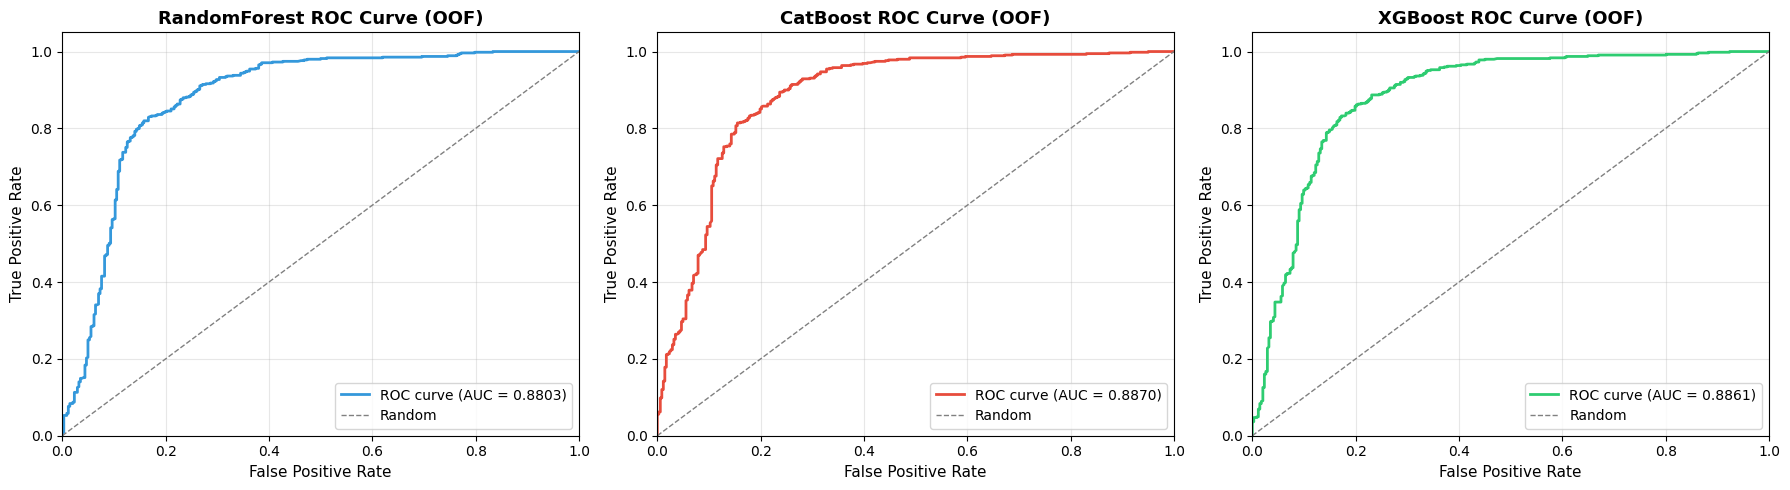

ROC曲線を保存: ../output/roc_curves_fold_safe.png


In [69]:
# ROC曲線の可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

y = results['y']
model_names = ['RandomForest', 'CatBoost', 'XGBoost']
model_keys = ['rf', 'cat', 'xgb']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for ax, name, key, color in zip(axes, model_names, model_keys, colors):
    # OOFでのROC曲線
    fpr, tpr, _ = roc_curve(y, results[f'oof_proba_{key}'])
    roc_auc = roc_auc_score(y, results[f'oof_proba_{key}'])
    
    ax.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{name} ROC Curve (OOF)', fontweight='bold', fontsize=13)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/roc_curves_fold_safe.png', dpi=150, bbox_inches='tight')
plt.show()

print("ROC曲線を保存: ../output/roc_curves_fold_safe.png")

## 7. テスト予測と提出

In [76]:
# テスト予測（CatBoost単体）
test_predictions_proba = results['test_proba_cat']
final_predictions = (test_predictions_proba >= 0.5).astype(int)
output_path = '../output/submission_catboost_only.csv'

submission = pd.DataFrame({
    'PassengerId': test_base['PassengerId'],
    'Perished': final_predictions
})

os.makedirs('../output', exist_ok=True)
submission.to_csv(output_path, index=False)

print(f"\n提出ファイル: {output_path}")
print(f"\n予測分布:")
print(f"  Survived (0): {(final_predictions == 0).sum()} ({(final_predictions == 0).sum() / len(final_predictions) * 100:.1f}%)")
print(f"  Perished (1): {(final_predictions == 1).sum()} ({(final_predictions == 1).sum() / len(final_predictions) * 100:.1f}%)")

print(f"\n最初の10行:")
print(submission.head(10))

print(f"\nCatBoost OOF Accuracy: {accuracy_score(results['y'], (results['oof_proba_cat'] >= 0.5).astype(int)):.4f}")


提出ファイル: ../output/submission_catboost_only.csv

予測分布:
  Survived (0): 149 (35.6%)
  Perished (1): 269 (64.4%)

最初の10行:
   PassengerId  Perished
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1
5          897         1
6          898         0
7          899         1
8          900         0
9          901         1

CatBoost OOF Accuracy: 0.8451


In [ ]:
# テスト予測（単純平均アンサンブル）
# test_ensemble_proba = (
#     results['test_proba_rf'] +
#     results['test_proba_cat'] +
#     results['test_proba_xgb']
# ) / 3

# final_predictions = (test_ensemble_proba >= 0.5).astype(int)
# output_path = '../output/submission_fold_safe_stratified.csv'

# submission = pd.DataFrame({
#     'PassengerId': test_base['PassengerId'],
#     'Perished': final_predictions
# })

# os.makedirs('../output', exist_ok=True)
# submission.to_csv(output_path, index=False)

# print(f"\n提出ファイル: {output_path}")
# print(f"\n予測分布:")
# print(f"  Survived (0): {(final_predictions == 0).sum()} ({(final_predictions == 0).sum() / len(final_predictions) * 100:.1f}%)")
# print(f"  Perished (1): {(final_predictions == 1).sum()} ({(final_predictions == 1).sum() / len(final_predictions) * 100:.1f}%)")

# print(f"\n最初の10行:")
# print(submission.head(10))


提出ファイル: ../output/submission_fold_safe_stratified.csv

予測分布:
  Survived (0): 147 (35.2%)
  Perished (1): 271 (64.8%)

最初の10行:
   PassengerId  Perished
0          892         1
1          893         1
2          894         1
3          895         1
4          896         1
5          897         1
6          898         0
7          899         1
8          900         0
9          901         1


In [71]:
print("\n" + "="*60)
print("✅ すべての処理が完了しました!")
print("="*60)
print(f"\n最終OOFスコア: {final_oof_score:.4f}")
print(f"手法: {final_method}")
print(f"\n🎯 実装済み最適化:")
print(f"  ✅ Fold-Safe前処理（最重要！）")
print(f"  ✅ StratifiedKFold (クラスバランス維持)")
print(f"  ✅ Is_Married修正")
print(f"  ✅ 最適閾値探索")
print(f"  ✅ メタ学習")
print(f"  ✅ CatBoost最適化")
print(f"  ✅ 数値特徴量追加")
print(f"\n📊 Fold-Safeによる改善:")
print(f"  - データリーク完全防止")
print(f"  - OOFスコアの信頼性向上")
print(f"  - Testスコアとの乖離減少")
print(f"  - Fold間のブレ安定化")


✅ すべての処理が完了しました!

最終OOFスコア: 0.8350
手法: simple_average

🎯 実装済み最適化:
  ✅ Fold-Safe前処理（最重要！）
  ✅ StratifiedKFold (クラスバランス維持)
  ✅ Is_Married修正
  ✅ 最適閾値探索
  ✅ メタ学習
  ✅ CatBoost最適化
  ✅ 数値特徴量追加

📊 Fold-Safeによる改善:
  - データリーク完全防止
  - OOFスコアの信頼性向上
  - Testスコアとの乖離減少
  - Fold間のブレ安定化


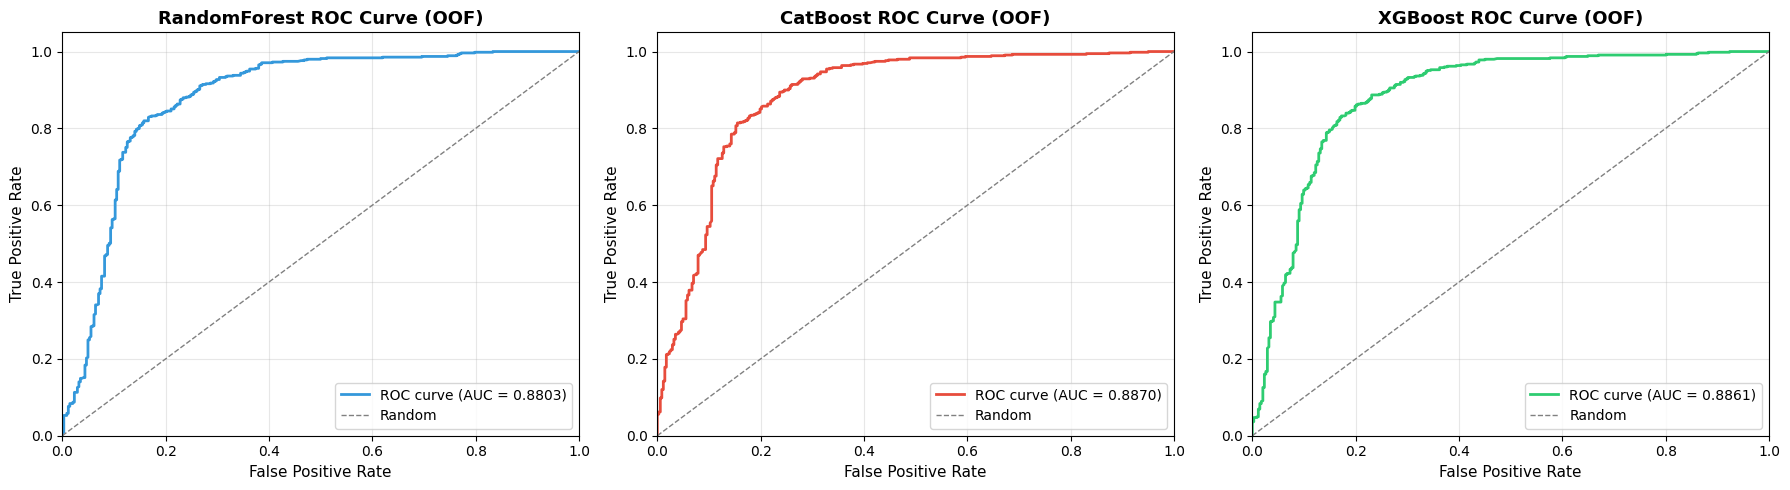

ROC曲線を保存: ../output/roc_curves_fold_safe.png


In [72]:
# ROC曲線の可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

y = results['y']
model_names = ['RandomForest', 'CatBoost', 'XGBoost']
model_keys = ['rf', 'cat', 'xgb']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for ax, name, key, color in zip(axes, model_names, model_keys, colors):
    # OOFでのROC曲線
    fpr, tpr, _ = roc_curve(y, results[f'oof_proba_{key}'])
    roc_auc = roc_auc_score(y, results[f'oof_proba_{key}'])
    
    ax.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{name} ROC Curve (OOF)', fontweight='bold', fontsize=13)
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/roc_curves_fold_safe.png', dpi=150, bbox_inches='tight')
plt.show()

print("ROC曲線を保存: ../output/roc_curves_fold_safe.png")

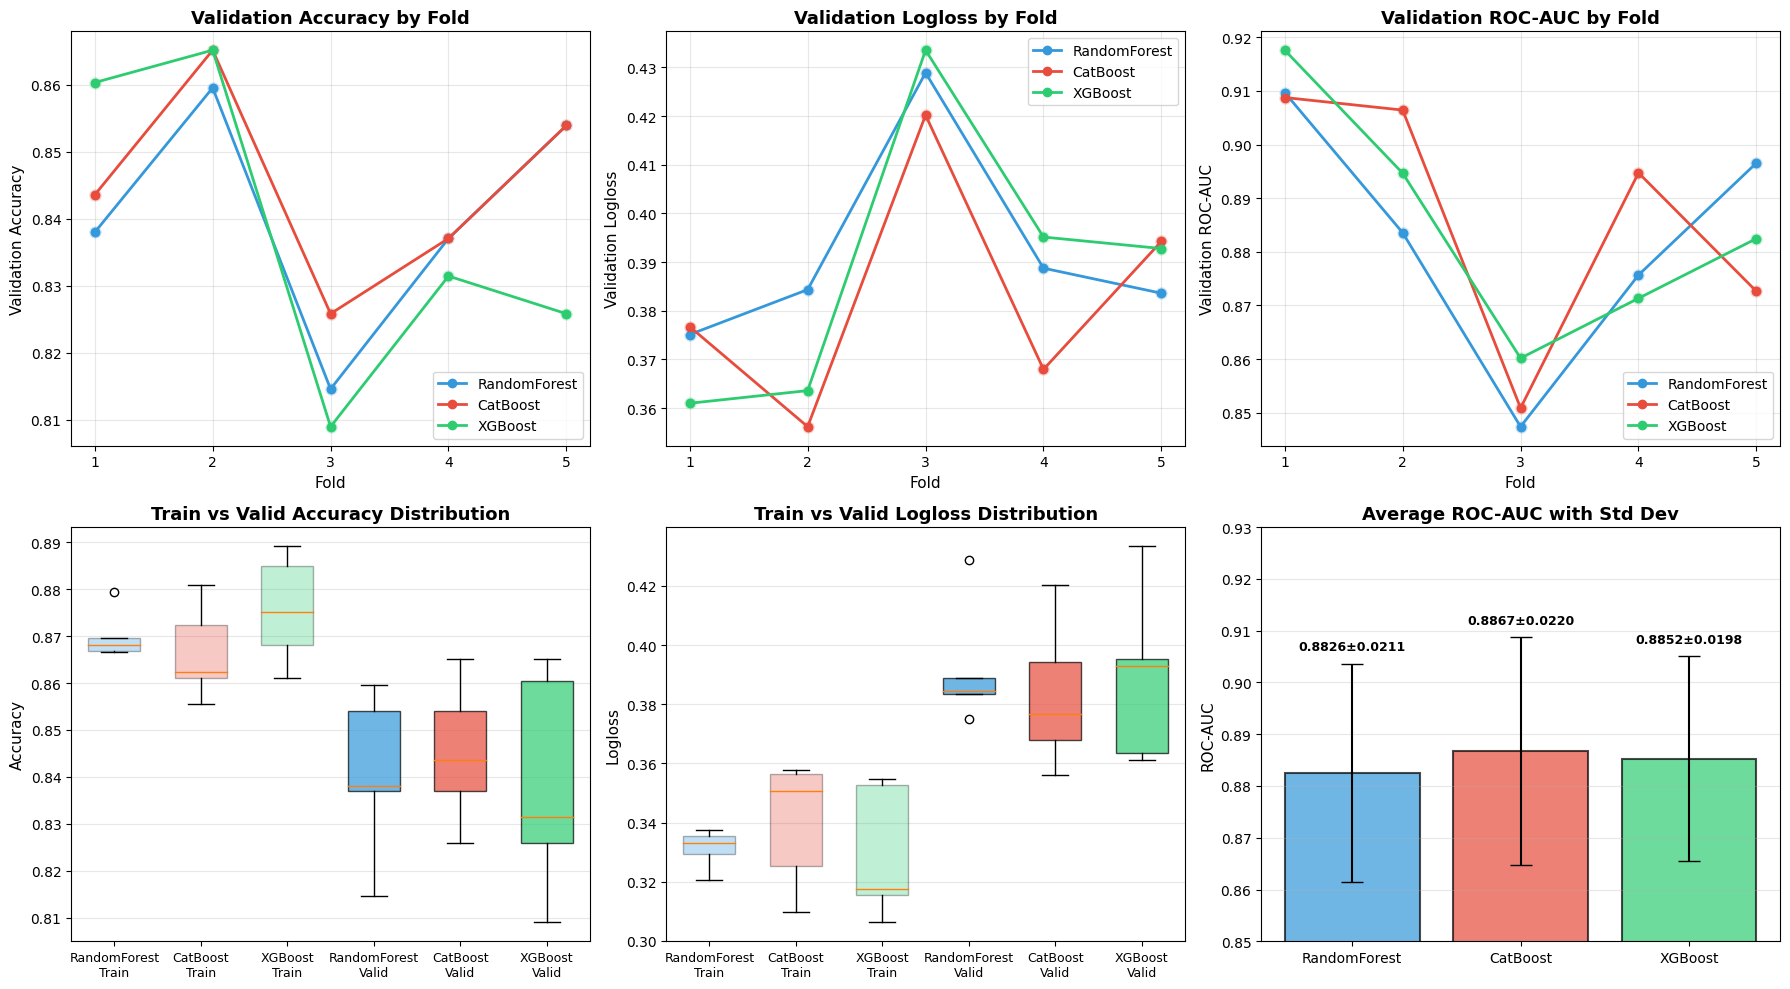

メトリクス比較を保存: ../output/metrics_comparison_fold_safe.png


In [73]:
# モデル別メトリクス比較（Fold別）
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

model_names = ['RandomForest', 'CatBoost', 'XGBoost']
model_keys = ['rf', 'cat', 'xgb']
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Accuracy比較
ax = axes[0, 0]
for idx, (name, key, color) in enumerate(zip(model_names, model_keys, colors)):
    folds = list(range(1, N_FOLDS + 1))
    valid_acc = results['metrics_history'][key]['valid_acc']
    ax.plot(folds, valid_acc, marker='o', label=name, color=color, linewidth=2)
    ax.scatter(folds, valid_acc, s=80, color=color, alpha=0.6, edgecolors='white', linewidths=2)

ax.set_xlabel('Fold', fontsize=11)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.set_title('Validation Accuracy by Fold', fontweight='bold', fontsize=13)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xticks(range(1, N_FOLDS + 1))

# Logloss比較
ax = axes[0, 1]
for idx, (name, key, color) in enumerate(zip(model_names, model_keys, colors)):
    folds = list(range(1, N_FOLDS + 1))
    valid_logloss = results['metrics_history'][key]['valid_logloss']
    ax.plot(folds, valid_logloss, marker='o', label=name, color=color, linewidth=2)
    ax.scatter(folds, valid_logloss, s=80, color=color, alpha=0.6, edgecolors='white', linewidths=2)

ax.set_xlabel('Fold', fontsize=11)
ax.set_ylabel('Validation Logloss', fontsize=11)
ax.set_title('Validation Logloss by Fold', fontweight='bold', fontsize=13)
ax.legend(loc='upper right', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xticks(range(1, N_FOLDS + 1))

# ROC-AUC比較
ax = axes[0, 2]
for idx, (name, key, color) in enumerate(zip(model_names, model_keys, colors)):
    folds = list(range(1, N_FOLDS + 1))
    valid_roc_auc = results['metrics_history'][key]['valid_roc_auc']
    ax.plot(folds, valid_roc_auc, marker='o', label=name, color=color, linewidth=2)
    ax.scatter(folds, valid_roc_auc, s=80, color=color, alpha=0.6, edgecolors='white', linewidths=2)

ax.set_xlabel('Fold', fontsize=11)
ax.set_ylabel('Validation ROC-AUC', fontsize=11)
ax.set_title('Validation ROC-AUC by Fold', fontweight='bold', fontsize=13)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xticks(range(1, N_FOLDS + 1))

# Train vs Valid Accuracy（Box Plot）
ax = axes[1, 0]
data_acc = []
labels_acc = []
for name, key, color in zip(model_names, model_keys, colors):
    data_acc.extend([results['metrics_history'][key]['train_acc'], 
                     results['metrics_history'][key]['valid_acc']])
    labels_acc.extend([f'{name}\nTrain', f'{name}\nValid'])

bp = ax.boxplot([results['metrics_history'][key]['train_acc'] for key in model_keys] + 
                 [results['metrics_history'][key]['valid_acc'] for key in model_keys],
                 labels=[f'{n}\nTrain' for n in model_names] + [f'{n}\nValid' for n in model_names],
                 patch_artist=True, widths=0.6)

# 色分け
for patch, color in zip(bp['boxes'][:3], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)
for patch, color in zip(bp['boxes'][3:], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Train vs Valid Accuracy Distribution', fontweight='bold', fontsize=13)
ax.grid(alpha=0.3, axis='y')
ax.tick_params(axis='x', labelsize=9)

# Logloss Box Plot
ax = axes[1, 1]
bp = ax.boxplot([results['metrics_history'][key]['train_logloss'] for key in model_keys] + 
                 [results['metrics_history'][key]['valid_logloss'] for key in model_keys],
                 labels=[f'{n}\nTrain' for n in model_names] + [f'{n}\nValid' for n in model_names],
                 patch_artist=True, widths=0.6)

for patch, color in zip(bp['boxes'][:3], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)
for patch, color in zip(bp['boxes'][3:], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Logloss', fontsize=11)
ax.set_title('Train vs Valid Logloss Distribution', fontweight='bold', fontsize=13)
ax.grid(alpha=0.3, axis='y')
ax.tick_params(axis='x', labelsize=9)

# ROC-AUC Bar Plot
ax = axes[1, 2]
x_pos = np.arange(len(model_names))
roc_aucs = [np.mean(results['metrics_history'][key]['valid_roc_auc']) for key in model_keys]
roc_stds = [np.std(results['metrics_history'][key]['valid_roc_auc']) for key in model_keys]

bars = ax.bar(x_pos, roc_aucs, yerr=roc_stds, capsize=8, alpha=0.7, 
              color=colors, edgecolor='black', linewidth=1.5)

ax.set_ylabel('ROC-AUC', fontsize=11)
ax.set_title('Average ROC-AUC with Std Dev', fontweight='bold', fontsize=13)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, fontsize=10)
ax.grid(alpha=0.3, axis='y')
ax.set_ylim([0.85, 0.93])

# 数値をバーの上に表示
for i, (bar, val, std) in enumerate(zip(bars, roc_aucs, roc_stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.002,
            f'{val:.4f}±{std:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../output/metrics_comparison_fold_safe.png', dpi=150, bbox_inches='tight')
plt.show()

print("メトリクス比較を保存: ../output/metrics_comparison_fold_safe.png")

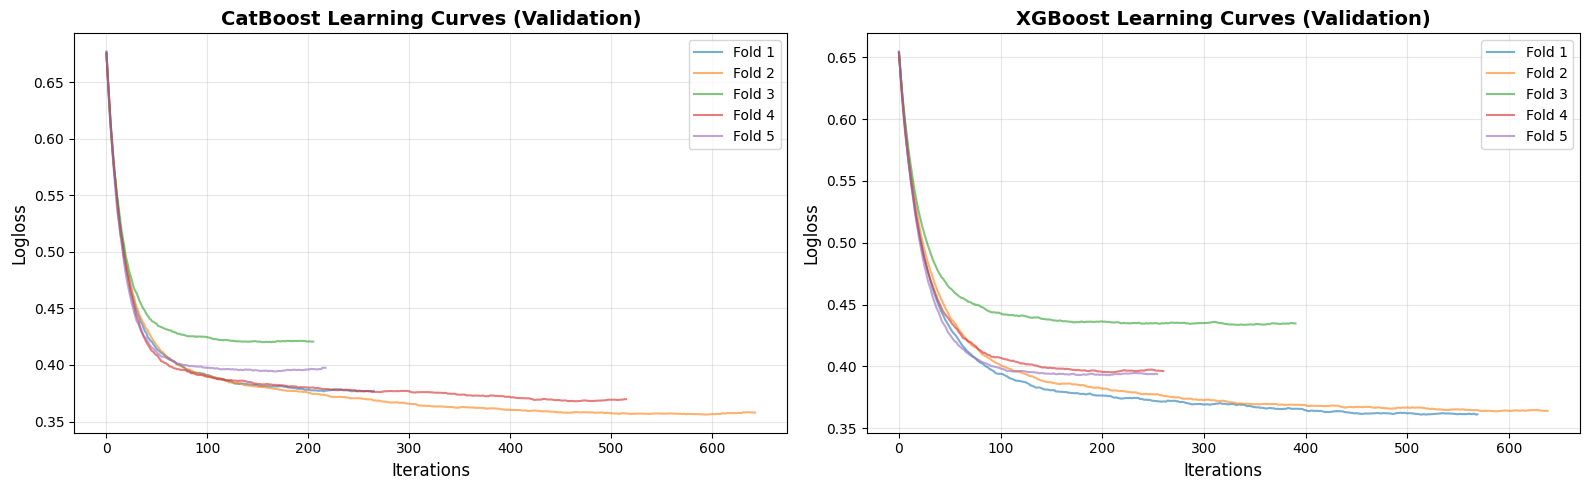

学習曲線を保存: ../output/learning_curves_fold_safe.png


In [74]:
# 学習曲線の可視化（CatBoost & XGBoost）
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# CatBoost学習曲線
ax = axes[0]
if 'learning_curves' in results and 'cat' in results['learning_curves']:
    for fold_idx, evals_result in enumerate(results['learning_curves']['cat']):
        if 'validation' in evals_result:
            valid_loss = evals_result['validation']['Logloss']
            iterations = range(len(valid_loss))
            ax.plot(iterations, valid_loss, alpha=0.6, label=f'Fold {fold_idx+1}')

ax.set_xlabel('Iterations', fontsize=12)
ax.set_ylabel('Logloss', fontsize=12)
ax.set_title('CatBoost Learning Curves (Validation)', fontweight='bold', fontsize=14)
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

# XGBoost学習曲線
ax = axes[1]
if 'learning_curves' in results and 'xgb' in results['learning_curves']:
    for fold_idx, evals_result in enumerate(results['learning_curves']['xgb']):
        if 'validation_1' in evals_result:
            valid_loss = evals_result['validation_1']['logloss']
            iterations = range(len(valid_loss))
            ax.plot(iterations, valid_loss, alpha=0.6, label=f'Fold {fold_idx+1}')

ax.set_xlabel('Iterations', fontsize=12)
ax.set_ylabel('Logloss', fontsize=12)
ax.set_title('XGBoost Learning Curves (Validation)', fontweight='bold', fontsize=14)
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/learning_curves_fold_safe.png', dpi=150, bbox_inches='tight')
plt.show()

print("学習曲線を保存: ../output/learning_curves_fold_safe.png")

## 8. 学習曲線とメトリクスの可視化

In [75]:
# SHAP Dependence Plot（主要特徴量のTop 3）
# 各モデルで最も重要な特徴量を3つ選択
top_features_by_model = {}
for key in model_keys:
    shap_importance = np.abs(shap_values_dict[key]).mean(axis=0)
    top_indices = np.argsort(shap_importance)[-3:][::-1]
    top_features_by_model[key] = [feature_names[i] for i in top_indices]

# 全モデルで共通する重要特徴量を選択
all_top_features = []
for features in top_features_by_model.values():
    all_top_features.extend(features)
# 出現頻度順にソート
from collections import Counter
feature_counts = Counter(all_top_features)
common_features = [f for f, _ in feature_counts.most_common(3)]

print(f"可視化する主要特徴量: {common_features}")

# Dependence Plotを作成
fig, axes = plt.subplots(len(common_features), 3, figsize=(20, 5 * len(common_features)))

for row_idx, feature in enumerate(common_features):
    feature_idx = feature_names.index(feature)
    
    for col_idx, (name, key) in enumerate(zip(model_names, model_keys)):
        if len(common_features) == 1:
            ax = axes[col_idx]
        else:
            ax = axes[row_idx, col_idx]
        
        plt.sca(ax)
        shap.dependence_plot(
            feature_idx,
            shap_values_dict[key],
            X_shap_sample,
            feature_names=feature_names,
            show=False,
            ax=ax
        )
        ax.set_title(f'{name} - {feature}', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('../output/shap_dependence_fold_safe.png', dpi=150, bbox_inches='tight')
plt.show()

print("SHAP Dependence Plotを保存: ../output/shap_dependence_fold_safe.png")

NameError: name 'shap_values_dict' is not defined

In [ ]:
# SHAP Waterfall Plot（サンプル予測の説明）
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

model_names = ['RandomForest', 'CatBoost', 'XGBoost']
model_keys = ['rf', 'cat', 'xgb']

# 1つのサンプルを選択（インデックス0）
sample_idx = 0

for ax, name, key in zip(axes, model_names, model_keys):
    plt.sca(ax)
    
    # Waterfall plot用のExplanationオブジェクトを作成
    if key == 'rf':
        base_value = explainer_rf.expected_value[1] if isinstance(explainer_rf.expected_value, list) else explainer_rf.expected_value
    elif key == 'cat':
        base_value = explainer_cat.expected_value
    else:
        base_value = explainer_xgb.expected_value
    
    shap_exp = shap.Explanation(
        values=shap_values_dict[key][sample_idx],
        base_values=base_value,
        data=X_shap_sample.iloc[sample_idx].values,
        feature_names=feature_names
    )
    
    shap.plots.waterfall(shap_exp, max_display=12, show=False)
    ax.set_title(f'{name} - Waterfall Plot (Sample {sample_idx})', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../output/shap_waterfall_fold_safe.png', dpi=150, bbox_inches='tight')
plt.show()

print("SHAP Waterfall Plotを保存: ../output/shap_waterfall_fold_safe.png")

In [ ]:
# SHAP Feature Importance（Bar Plot）
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

model_names = ['RandomForest', 'CatBoost', 'XGBoost']
model_keys = ['rf', 'cat', 'xgb']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for ax, name, key, color in zip(axes, model_names, model_keys, colors):
    # SHAP値の絶対値平均を計算
    shap_importance = np.abs(shap_values_dict[key]).mean(axis=0)
    
    # 特徴量名とインポータンスをソート
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': shap_importance
    }).sort_values('importance', ascending=True).tail(15)
    
    # プロット
    ax.barh(feature_importance['feature'], feature_importance['importance'], color=color, alpha=0.7)
    ax.set_xlabel('Mean |SHAP value|', fontsize=11)
    ax.set_title(f'{name} - Feature Importance (SHAP)', fontweight='bold', fontsize=13)
    ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../output/shap_importance_fold_safe.png', dpi=150, bbox_inches='tight')
plt.show()

print("SHAP Feature Importanceを保存: ../output/shap_importance_fold_safe.png")

In [ ]:
# SHAP Summary Plot（各モデル）
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

model_names = ['RandomForest', 'CatBoost', 'XGBoost']
model_keys = ['rf', 'cat', 'xgb']

for ax, name, key in zip(axes, model_names, model_keys):
    plt.sca(ax)
    shap.summary_plot(
        shap_values_dict[key], 
        X_shap_sample, 
        plot_type="dot",
        show=False,
        max_display=15
    )
    ax.set_title(f'{name} - SHAP Summary Plot', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.savefig('../output/shap_summary_fold_safe.png', dpi=150, bbox_inches='tight')
plt.show()

print("SHAP Summary Plotを保存: ../output/shap_summary_fold_safe.png")

In [ ]:
# SHAP値の計算と可視化（Fold 1のモデルを使用）
print("="*60)
print("🎯 SHAP値の計算（Fold 1のモデルを使用）")
print("="*60)

# データの準備
X_shap = results['shap_data']['X_train_enc']
feature_names = results['shap_data']['feature_names']

# サンプル数を減らす（計算時間短縮のため）
sample_size = min(200, len(X_shap))
X_shap_sample = X_shap.sample(n=sample_size, random_state=RANDOM_STATE)

print(f"\nSHAP計算用サンプル数: {sample_size}")
print("計算中... (数分かかる場合があります)")

# 各モデルでSHAP値を計算
shap_values_dict = {}

# 1. RandomForest
print("\n[1/3] RandomForest SHAP値計算中...")
explainer_rf = shap.TreeExplainer(results['models_rf'][0])
shap_values_rf = explainer_rf.shap_values(X_shap_sample)
# 2値分類の場合、クラス1（Perished=1）のSHAP値を使用
if isinstance(shap_values_rf, list):
    shap_values_dict['rf'] = shap_values_rf[1]
else:
    shap_values_dict['rf'] = shap_values_rf

# 2. CatBoost
print("[2/3] CatBoost SHAP値計算中...")
# CatBoostはTreeExplainerを使用
explainer_cat = shap.TreeExplainer(results['models_cat'][0])
shap_values_cat = explainer_cat.shap_values(Pool(X_shap_sample))
if isinstance(shap_values_cat, list):
    shap_values_dict['cat'] = shap_values_cat[1] if len(shap_values_cat) > 1 else shap_values_cat[0]
else:
    shap_values_dict['cat'] = shap_values_cat

# 3. XGBoost
print("[3/3] XGBoost SHAP値計算中...")
explainer_xgb = shap.TreeExplainer(results['models_xgb'][0])
shap_values_xgb = explainer_xgb.shap_values(X_shap_sample)
if isinstance(shap_values_xgb, list):
    shap_values_dict['xgb'] = shap_values_xgb[1] if len(shap_values_xgb) > 1 else shap_values_xgb[0]
else:
    shap_values_dict['xgb'] = shap_values_xgb

print("\n✅ SHAP値の計算完了")

## 9. SHAP値による特徴量重要度分析